In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#=====================================================
# 1. Read Data
#=====================================================
df = pd.read_csv('/content/heart.csv')
print(df.head())

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

#=====================================================
# 2. GWO Implementation
#=====================================================
def decode_solution(wolf):
    criterion_code = int(round(wolf[0]))
    criterion = 'gini' if criterion_code == 0 else 'entropy'

    max_depth = int(round(wolf[1]))
    max_depth = np.clip(max_depth, 2, 10)

    min_samples_split = int(round(wolf[2]))
    min_samples_split = np.clip(min_samples_split, 2, 10)

    min_samples_leaf = int(round(wolf[3]))
    min_samples_leaf = np.clip(min_samples_leaf, 1, 10)

    return {
        'criterion': criterion,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    }

def initialize_population(pop_size, dim, bounds):
    population = []
    for _ in range(pop_size):
        wolf = np.array([random.uniform(bounds[i][0], bounds[i][1]) for i in range(dim)])
        population.append(wolf)
    return population

def fitness_function(wolf, X, y):
    params = decode_solution(wolf)
    model = DecisionTreeClassifier(
        criterion=params['criterion'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=42
    )
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    return np.mean(scores)

def update_position(wolf, alpha, beta, delta, a, dim, bounds):
    new_wolf = np.copy(wolf)
    for i in range(dim):
        r1 = random.random()
        r2 = random.random()
        A1 = 2*a*r1 - a
        C1 = 2*r2

        D_alpha = abs(C1*alpha[i] - wolf[i])
        X1 = alpha[i] - A1*D_alpha

        r1 = random.random()
        r2 = random.random()
        A2 = 2*a*r1 - a
        C2 = 2*r2

        D_beta = abs(C2*beta[i] - wolf[i])
        X2 = beta[i] - A2*D_beta

        r1 = random.random()
        r2 = random.random()
        A3 = 2*a*r1 - a
        C3 = 2*r2

        D_delta = abs(C3*delta[i] - wolf[i])
        X3 = delta[i] - A3*D_delta

        new_wolf[i] = (X1 + X2 + X3) / 3.0
        new_wolf[i] = np.clip(new_wolf[i], bounds[i][0], bounds[i][1])

    return new_wolf
fitness_history = []
def advanced_gwo(X, y, pop_size=10, max_iter=20):
    dim = 4
    bounds = [(0, 1), (2, 10), (2, 10), (1, 10)]

    wolves = initialize_population(pop_size, dim, bounds)
    fitness = [fitness_function(w, X, y) for w in wolves]

    alpha_idx = np.argmax(fitness)
    alpha = wolves[alpha_idx]
    alpha_fitness = fitness[alpha_idx]

    sorted_indices = np.argsort(fitness)[::-1]
    beta = wolves[sorted_indices[1]]
    beta_fitness = fitness[sorted_indices[1]]
    delta = wolves[sorted_indices[2]]
    delta_fitness = fitness[sorted_indices[2]]

    for iteration in range(max_iter):
        a = 2 - iteration*(2/max_iter)

        for i in range(pop_size):
            wolves[i] = update_position(wolves[i], alpha, beta, delta, a, dim, bounds)
            fitness[i] = fitness_function(wolves[i], X, y)

        alpha_idx = np.argmax(fitness)
        alpha = wolves[alpha_idx]
        alpha_fitness = fitness[alpha_idx]

        sorted_indices = np.argsort(fitness)[::-1]
        beta = wolves[sorted_indices[1]]
        beta_fitness = fitness[sorted_indices[1]]
        delta = wolves[sorted_indices[2]]
        delta_fitness = fitness[sorted_indices[2]]

        fitness_history.append(alpha_fitness)  # حفظ الدقة لكل تكرار

        print(f"Iteration {iteration+1}/{max_iter} | Best Fitness: {alpha_fitness:.4f}")

    return alpha, alpha_fitness

#=====================================================
# 3. Run GWO & Train Final Model
#=====================================================
best_wolf, best_fitness = advanced_gwo(X_train, y_train, pop_size=15, max_iter=30)
print("\nBest Wolf (raw vector):", best_wolf)
print("Best CV Accuracy (Alpha Fitness):", best_fitness)

best_params = decode_solution(best_wolf)
print("Best Hyperparameters:", best_params)

# Train final model
final_model = DecisionTreeClassifier(
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_model.fit(X_train, y_train)

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
Training Data: (820, 13), Testing Data: (205, 13)
Iteration 1/30 | Best Fitness: 0.9659
Iteration 2/30 | Best Fitness: 0.9841
Iteration 3/30 | Best Fitness: 0.9841
Iteration 4/30 | Best Fitness: 0.9854
Iteration 5/30 | Best Fitness: 0.9854
Iteration 6/30 | Best Fitness: 0.9854
Iteration 7/30 | Best Fitness: 0.9854
Iteration 8/30 | Best Fitness: 0.9854
Iteration 9/30 | Best Fitne

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [5]:
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOptimized Decision Tree Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Optimized Decision Tree Test Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [6]:
print("\n=== Final GWO Results ===")
print(f"Best Fitness (CV Accuracy): {best_fitness:.4f}")
print(f"Best Hyperparameters: {decode_solution(best_wolf)}")


=== Final GWO Results ===
Best Fitness (CV Accuracy): 0.9854
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}


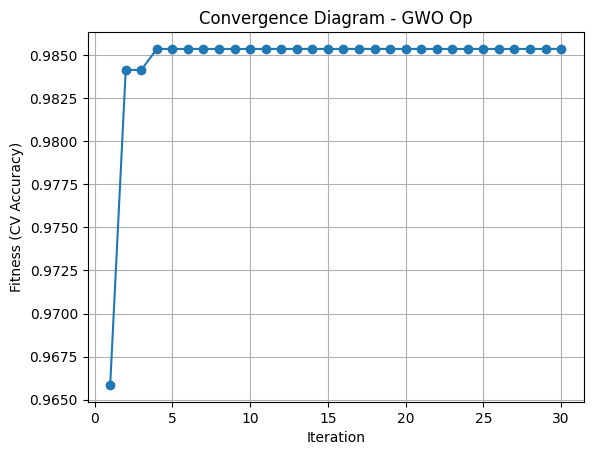

In [7]:
# Convergence Diagram
plt.plot(range(1, len(fitness_history) + 1), fitness_history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Fitness (CV Accuracy)")
plt.title("Convergence Diagram - GWO Op")
plt.grid()
plt.show()

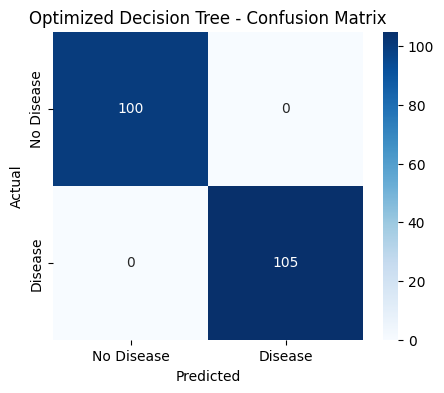

In [8]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["No Disease", "Disease"],
            yticklabels=["No Disease", "Disease"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Optimized Decision Tree - Confusion Matrix")
plt.show()

In [9]:
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n=== Optimized Model Accuracy ===")
print(f"Test Accuracy: {accuracy:.4f}")


=== Optimized Model Accuracy ===
Test Accuracy: 1.0000


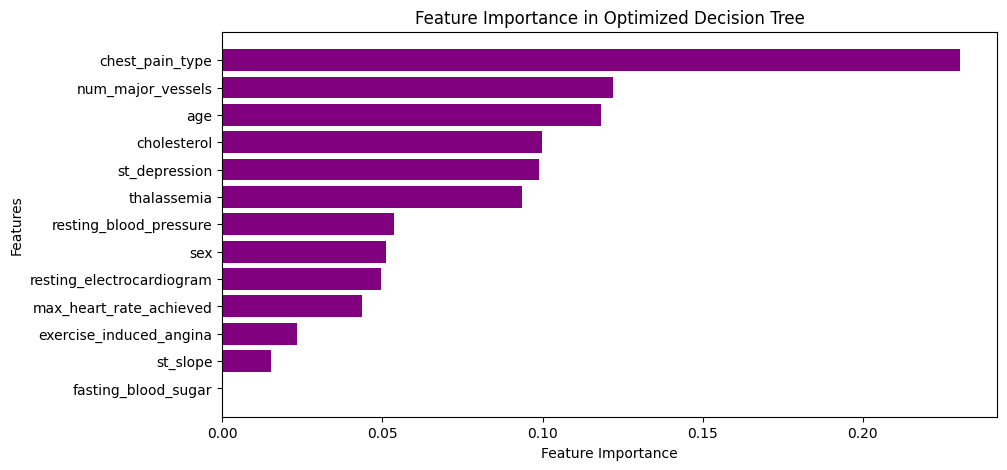

In [10]:
feature_importance = final_model.feature_importances_

# DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

columns = {'cp':'chest_pain_type',
               'trestbps':'resting_blood_pressure',
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram',
               'thalach': 'max_heart_rate_achieved',
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression',
               'slope': 'st_slope',
               'ca':'num_major_vessels',
               'thal': 'thalassemia'}
feature_importance_df['Feature'] = feature_importance_df['Feature'].replace(columns)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='purple')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Optimized Decision Tree")
plt.gca().invert_yaxis()
plt.show()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier

optimized_model = DecisionTreeClassifier()
optimized_model.fit(X_train, y_train)

classifiers = {
    "Decision Tree (GWO Optimized)": optimized_model,

}

metrics = ["Accuracy", "ROC_AUC", "Recall", "Precision", "F1 Score"]
results = [
    [
        name,
        accuracy_score(y_test, y_pred := model.predict(X_test)) * 100,
        roc_auc_score(y_test, y_pred) * 100,
        recall_score(y_test, y_pred) * 100,
        precision_score(y_test, y_pred) * 100,
        f1_score(y_test, y_pred) * 100
    ]
    for name, model in classifiers.items()
]

results_df = pd.DataFrame(results, columns=["Classifier"] + metrics).sort_values(by="Accuracy", ascending=False)

def highlight_best(s, color):
    """ تمييز أعلى قيمة بلون معين """
    return [f'background-color: {color}; color: white' if v == s.max() else '' for v in s]

styled_results = (
    results_df.style
    .set_properties(**{"text-align": "center", "font-size": "12pt", "border": "1px solid #ddd"})
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "13pt"), ("background-color", "#333"), ("color", "white")]}
    ])
    .apply(highlight_best, color="#3498db", subset=["Accuracy"])
    .apply(highlight_best, color="#2ecc71", subset=["ROC_AUC"])
    .apply(highlight_best, color="#e74c3c", subset=["Recall"])
    .apply(highlight_best, color="#f39c12", subset=["Precision"])
    .apply(highlight_best, color="#9b59b6", subset=["F1 Score"])
)

styled_results

,Classifier,Accuracy,ROC_AUC,Recall,Precision,F1 Score
0,Decision Tree (GWO Optimized),98.536585,98.571429,97.142857,100.000000,98.550725



=== Model Overfitting Check ===
Training Accuracy: 1.0000
Testing Accuracy: 0.9854
Cross-Validation Mean Accuracy: 0.9890 ± 0.0060

Training Data Distribution:
 target
1    0.513415
0    0.486585
Name: proportion, dtype: float64

Testing Data Distribution:
 target
1    0.512195
0    0.487805
Name: proportion, dtype: float64


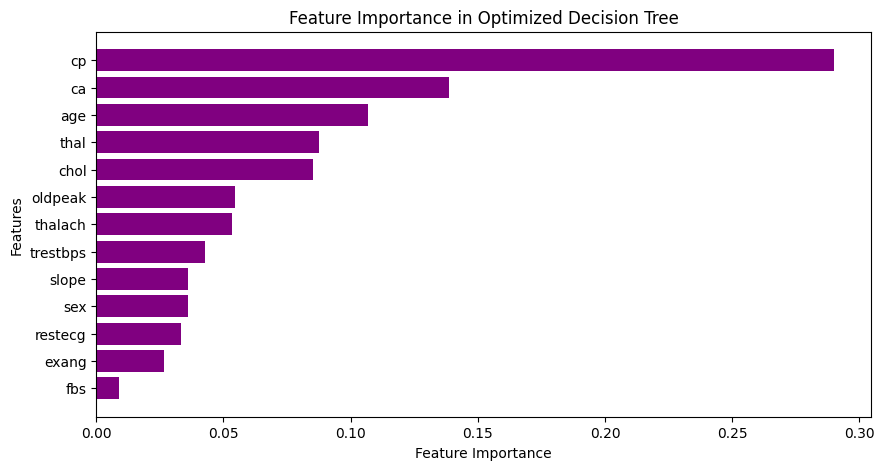

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
import numpy as np

train_accuracy = accuracy_score(y_train, optimized_model.predict(X_train))
test_accuracy = accuracy_score(y_test, optimized_model.predict(X_test))

cv_scores = cross_val_score(optimized_model, X_train, y_train, cv=5, scoring='accuracy')
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)

feature_importance = optimized_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by="Importance", ascending=False)


print("\n=== Model Overfitting Check ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Cross-Validation Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print("\nTraining Data Distribution:\n", train_distribution)
print("\nTesting Data Distribution:\n", test_distribution)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='purple')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Optimized Decision Tree")
plt.gca().invert_yaxis()
plt.show()

In [14]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Page configuration
st.set_page_config(
    page_title="GWO-Optimized Decision Tree",
    page_icon="🌲",
    layout="wide"
)

# Custom CSS for styling
st.markdown("""
<style>
    .main {background-color: #f9f9f9;}
    .stButton>button {background-color: #4CAF50; color: white;}
    .stSelectbox label, .stSlider label {font-weight: bold;}
    .metric-box {padding: 20px; border-radius: 10px; background-color: white; box-shadow: 0 2px 5px rgba(0,0,0,0.1);}
</style>
""", unsafe_allow_html=True)

# Sidebar controls
with st.sidebar:
    st.header("📁 Data & Parameters")
    uploaded_file = st.file_uploader("Upload your CSV file", type=["csv"])

    if uploaded_file is not None:
        df = pd.read_csv(uploaded_file)
        target_col = st.selectbox("Select target column", df.columns)
    else:
        df = None
        target_col = None

    st.header("⚙️ GWO Parameters")
    pop_size = st.slider("Population size", 5, 30, 15)
    max_iter = st.slider("Max iterations", 10, 50, 30)

# Main content area
st.title("🌲 GWO-Optimized Decision Tree Classifier")
st.markdown("---")

if uploaded_file is not None and target_col is not None:
    # Data preparation
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Data preview
    st.subheader("📋 Data Preview")
    st.dataframe(df.head(), use_container_width=True)

    # GWO implementation functions (from original code)
    # ... [Include all the GWO functions here] ...

    # Add Run button
    if st.button("🚀 Run GWO Optimization", use_container_width=True):
        with st.spinner("🔍 Optimizing hyperparameters..."):
            fitness_history.clear()
            best_wolf, best_fitness = advanced_gwo(X_train, y_train, pop_size=pop_size, max_iter=max_iter)
            best_params = decode_solution(best_wolf)

            # Train final model
            final_model = DecisionTreeClassifier(
                **best_params,
                random_state=42
            )
            final_model.fit(X_train, y_train)
            y_pred = final_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # Results display
            st.success("Optimization complete!")
            st.markdown("---")

            # Metrics columns
            col1, col2, col3 = st.columns(3)
            with col1:
                st.markdown("<div class='metric-box'>📈 Best CV Accuracy: **{:.4f}**</div>".format(best_fitness),
                           unsafe_allow_html=True)
            with col2:
                st.markdown("<div class='metric-box'>🎯 Test Accuracy: **{:.4f}**</div>".format(accuracy),
                           unsafe_allow_html=True)
            with col3:
                st.markdown("<div class='metric-box'>⚙️ Best Parameters: {} </div>".format(best_params),
                           unsafe_allow_html=True)

            # Visualizations
            st.markdown("---")
            col_viz1, col_viz2 = st.columns(2)

            with col_viz1:
                st.subheader("📈 Fitness Progress")
                fig1, ax1 = plt.subplots()
                ax1.plot(fitness_history, marker='o', color='#4CAF50')
                ax1.set_xlabel("Iteration", fontweight='bold')
                ax1.set_ylabel("Accuracy", fontweight='bold')
                plt.grid(True, alpha=0.3)
                st.pyplot(fig1)

            with col_viz2:
                st.subheader("📊 Confusion Matrix")
                cm = confusion_matrix(y_test, y_pred)
                fig2, ax2 = plt.subplots()
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
                ax2.set_xlabel('Predicted', fontweight='bold')
                ax2.set_ylabel('Actual', fontweight='bold')
                st.pyplot(fig2)

            # Prediction form
            st.markdown("---")
            st.subheader("🔮 Make a Prediction")
            with st.form("prediction_form"):
                cols = st.columns(3)
                input_data = {}
                for i, feature in enumerate(X.columns):
                    with cols[i % 3]:
                        input_data[feature] = st.number_input(
                            f"{feature}",
                            value=float(X[feature].mean()),
                            step=0.1
                        )

                if st.form_submit_button("Predict"):
                    input_df = pd.DataFrame([input_data])
                    prediction = final_model.predict(input_df)
                    st.success(f"🎯 Predicted class: **{prediction[0]}**")

else:
    st.warning("⚠️ Please upload a CSV file and select the target column to begin.")

# Include the GWO implementation functions here
# ... [Paste all the GWO functions from original code here] ...

2025-02-22 20:02:45.911 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:02:45.914 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:02:46.033 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-22 20:02:46.035 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:02:46.037 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:02:46.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-22 20:02:46.040 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn